In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from IPython.display import display
from scipy.optimize import fsolve

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Read trades from CSV
trades_df = pd.read_csv('trades.csv')
trades_df['Date'] = pd.to_datetime(trades_df['Date'])

# Sort by date
trades_df = trades_df.sort_values('Date').reset_index(drop=True)

# Calculate transaction fees
# Fee = |Total_Value| - (|Quantity| * Price)
# For buys: Total_Value is negative, so |Total_Value| > (Quantity * Price) → fee is positive
# For sells: Total_Value is positive, so (Quantity * Price) > |Total_Value| → fee is positive
# Use absolute value to ensure fee is always positive (it's a cost)
expected_value = trades_df['Quantity'].abs() * trades_df['Price']
trades_df['Fee_SEK'] = (trades_df['Total_Value'].abs() - expected_value).abs()

# Calculate fee as percentage of the transaction value
# Fee percentage = (Fee / (|Quantity| * Price)) * 100
trades_df['Fee_Percentage'] = (trades_df['Fee_SEK'] / expected_value) * 100

# Round for display
trades_df['Fee_SEK'] = trades_df['Fee_SEK'].round(2)
trades_df['Fee_Percentage'] = trades_df['Fee_Percentage'].round(2)

print("Trades loaded:")
display(trades_df)
print(f"\nTotal trades: {len(trades_df)}")



Trades loaded:


,Date,Account,Action,Stock,Quantity,Price,Total_Value,Fee_SEK,Fee_Percentage
0,2025-11-21,6530734,Köp,SCA B,1,118.05,-119.05,1.00,0.85
1,2025-11-24,6530734,Köp,SAAB B,2,465.50,-932.40,1.40,0.15
2,2025-11-25,6530734,Köp,Ericsson B,11,90.10,-992.59,1.49,0.15
3,2025-11-25,6530734,Köp,SAAB B,2,450.00,-901.35,1.35,0.15
4,2025-11-26,6530734,Sälj,SCA B,-1,122.60,121.60,1.00,0.82
5,2025-11-27,6530734,Sälj,SAAB B,-4,475.00,1897.15,2.85,0.15
6,2025-11-27,6530734,Sälj,Ericsson B,-11,91.02,999.72,1.50,0.15



Total trades: 7


In [2]:
# Calculate current positions (holdings)
positions = {}

for _, trade in trades_df.iterrows():
    stock = trade['Stock']
    quantity = trade['Quantity']
    
    if stock not in positions:
        positions[stock] = 0
    
    positions[stock] += quantity

# Filter out positions with zero quantity
current_positions = {stock: qty for stock, qty in positions.items() if qty != 0}

print("Current Portfolio Positions:")
if current_positions:
    positions_df = pd.DataFrame([
        {'Stock': stock, 'Quantity': qty} 
        for stock, qty in current_positions.items()
    ])
    display(positions_df)
else:
    print("No open positions - all positions have been closed")



Current Portfolio Positions:
No open positions - all positions have been closed


In [3]:
# Calculate portfolio value over time
# Track cash, positions, and NAV (Net Asset Value) using latest purchase prices
# Portfolio value = Cash + NAV (always)

portfolio_history = []
positions_over_time = {}
purchase_prices = {}  # Track latest purchase price for each stock (for NAV calculation)
cash_balance = 0  # Start with 0 cash
total_deposits = 0  # Track total deposits (for P&L calculation)

for _, trade in trades_df.iterrows():
    date = trade['Date']
    stock = trade['Stock']
    quantity = trade['Quantity']
    price = trade['Price']
    total_value = trade['Total_Value']  # Negative for buys, positive for sells (includes fees)
    fee = trade['Fee_SEK']
    
    # For buys: check if we have enough cash, if not assume a deposit to fully fund it
    if quantity > 0:  # This is a buy
        amount_needed = abs(total_value)  # Amount we need to spend (including fees)
        if cash_balance < amount_needed:
            # Assume a deposit to fully fund the purchase
            deposit_needed = amount_needed - cash_balance
            cash_balance += deposit_needed
            total_deposits += deposit_needed
    
    # Execute the trade
    # For buys: reduce cash by total_value (negative, so we add it which reduces cash)
    # For sells: increase cash by total_value (positive, so we add it which increases cash)
    cash_balance += total_value
    
    # Update positions
    if stock not in positions_over_time:
        positions_over_time[stock] = 0
    positions_over_time[stock] += quantity
    
    # Update purchase price for NAV calculation (only for buys)
    if quantity > 0:  # This is a buy
        purchase_prices[stock] = price  # Update to latest purchase price
    
    # Calculate NAV (Net Asset Value) using latest purchase prices
    nav = 0
    for pos_stock, pos_qty in positions_over_time.items():
        if pos_stock in purchase_prices and pos_qty > 0:
            # Use latest purchase price for this stock
            nav += pos_qty * purchase_prices[pos_stock]
    
    # Portfolio value = Cash + NAV (always)
    portfolio_value = cash_balance + nav
    
    # Calculate total fees up to this point
    total_fees = trades_df[trades_df['Date'] <= date]['Fee_SEK'].sum()
    
    # Calculate P&L (Profit & Loss)
    # P&L = Portfolio Value - Total Deposits
    pnl = portfolio_value - total_deposits
    
    portfolio_history.append({
        'Date': date,
        'Cash': cash_balance,
        'NAV': nav,
        'Portfolio_Value': portfolio_value,
        'Total_Fees': total_fees,
        'P&L': pnl,
        'Positions': positions_over_time.copy()
    })

portfolio_df = pd.DataFrame(portfolio_history)

print("Portfolio Value Over Time:")
display(portfolio_df[['Date', 'Cash', 'NAV', 'Portfolio_Value', 'Total_Fees', 'P&L']])



Portfolio Value Over Time:


,Date,Cash,NAV,Portfolio_Value,Total_Fees,P&L
0,2025-11-21,0.00,118.05,118.05,1.00,-1.00
1,2025-11-24,0.00,1049.05,1049.05,2.40,-2.40
2,2025-11-25,0.00,2040.15,2040.15,5.24,-3.89
3,2025-11-25,0.00,2909.15,2909.15,5.24,-36.24
4,2025-11-26,121.60,2791.10,2912.70,6.24,-32.69
5,2025-11-27,2018.75,991.10,3009.85,10.59,64.46
6,2025-11-27,3018.47,0.00,3018.47,10.59,73.08


In [4]:
# Calculate statistics
# Get current values from portfolio history
current_cash = portfolio_df.iloc[-1]['Cash']
current_nav = portfolio_df.iloc[-1]['NAV']
current_total_fees = portfolio_df.iloc[-1]['Total_Fees']
current_portfolio_value = portfolio_df.iloc[-1]['Portfolio_Value']
current_pnl = portfolio_df.iloc[-1]['P&L']

# Calculate total deposits (sum of all buy amounts including fees)
total_deposits = abs(trades_df[trades_df['Quantity'] > 0]['Total_Value'].sum())

# Initial investment = total deposits
initial_investment = total_deposits

# For return calculation: use current portfolio value
# Portfolio value = Cash + NAV
end_value_for_return = current_portfolio_value

# Calculate return percentage
# Return = (End Value - Initial Investment) / Initial Investment
if initial_investment > 0:
    total_return_pct = ((end_value_for_return - initial_investment) / initial_investment) * 100
else:
    total_return_pct = 0

# Calculate CAGR using Money-Weighted Return (IRR - Internal Rate of Return)
# This accounts for when deposits and withdrawals occurred
start_date = portfolio_df.iloc[0]['Date']
end_date = portfolio_df.iloc[-1]['Date']
days_held = (end_date - start_date).days
years_held = days_held / 365.25

# Build cash flow timeline for IRR calculation
# Deposits (buys) are negative (money going out)
# Withdrawals (sells) are positive (money coming in)
# Final portfolio value is positive (what we have now)

def npv_irr(rate, cash_flows, dates, end_date, end_value):
    """Calculate NPV for given rate"""
    npv = 0
    for i, (cf, date) in enumerate(zip(cash_flows, dates)):
        days_from_start = (date - start_date).days
        years_from_start = days_from_start / 365.25
        npv += cf / ((1 + rate) ** years_from_start)
    # Add final portfolio value
    total_years = (end_date - start_date).days / 365.25
    npv += end_value / ((1 + rate) ** total_years)
    return npv

# Collect all cash flows with their dates
# Only deposits (buys) count as cash flows - sells don't count because
# the proceeds stay in the portfolio as cash
cash_flows = []
cash_flow_dates = []

# Deposits (buys) - negative cash flows (money invested)
for _, trade in trades_df[trades_df['Quantity'] > 0].iterrows():
    cash_flows.append(-abs(trade['Total_Value']))  # Negative (money going out)
    cash_flow_dates.append(trade['Date'])

# Note: Sells are NOT cash flows because the proceeds stay in the portfolio as cash
# The final portfolio value already includes this cash

# Calculate IRR (money-weighted return)
if len(cash_flows) > 0 and current_portfolio_value > 0:
    try:
        # Solve for rate where NPV = 0
        # Use a reasonable initial guess (e.g., 0.1 = 10%)
        def npv_func(rate):
            return npv_irr(rate[0], cash_flows, cash_flow_dates, end_date, current_portfolio_value)
        
        # Try to find IRR
        initial_guess = 0.1
        irr_rate = fsolve(npv_func, initial_guess)[0]
        
        # Convert to percentage and annualize
        cagr = irr_rate * 100
        
        # Validate result (should be reasonable)
        if abs(cagr) > 10000:  # Unreasonable result
            cagr = 0.0
    except:
        # If IRR calculation fails, fall back to simple CAGR
        if years_held > 0 and initial_investment > 0:
            if end_value_for_return > 0:
                cagr = ((end_value_for_return / initial_investment) ** (1 / years_held) - 1) * 100
            else:
                cagr = -100.0
        else:
            cagr = 0.0
else:
    cagr = 0.0

print("PORTFOLIO STATISTICS")
stats_data = {
    'Metric': [
        'Start Date',
        'End Date',
        'Days Held',
        'Years Held',
        'Total Deposits',
        'Total Fees',
        'Cash',
        'NAV',
        'Portfolio Value',
        'P&L',
        'Total Return',
        'CAGR'
    ],
    'Value': [
        start_date.strftime('%Y-%m-%d'),
        end_date.strftime('%Y-%m-%d'),
        days_held,
        f'{years_held:.4f}',
        f'{total_deposits:,.2f} SEK',
        f'{current_total_fees:,.2f} SEK',
        f'{current_cash:,.2f} SEK',
        f'{current_nav:,.2f} SEK',
        f'{current_portfolio_value:,.2f} SEK',
        f'{current_pnl:,.2f} SEK',
        f'{total_return_pct:.2f}%',
        f'{cagr:.2f}%'
    ]
}
stats_df = pd.DataFrame(stats_data)
display(stats_df)



PORTFOLIO STATISTICS


,Metric,Value
0,Start Date,2025-11-21
1,End Date,2025-11-27
2,Days Held,6
3,Years Held,0.0164
4,Total Deposits,"2,945.39 SEK"
5,Total Fees,10.59 SEK
6,Cash,"3,018.47 SEK"
7,NAV,0.00 SEK
8,Portfolio Value,"3,018.47 SEK"
9,P&L,73.08 SEK


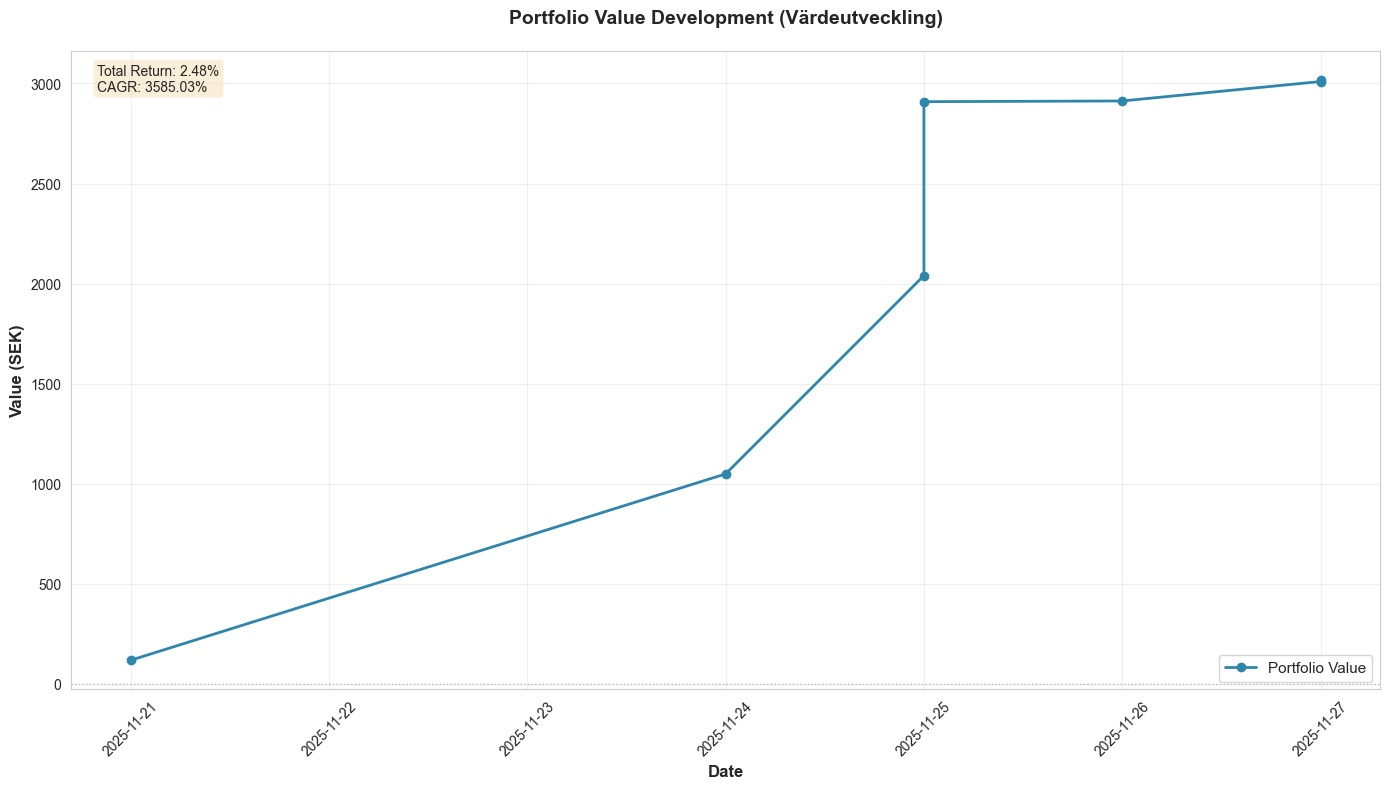

In [5]:
# Create graph of portfolio value development (värdeutveckling)
fig, ax = plt.subplots(figsize=(14, 8))

# Plot portfolio value over time
ax.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
        marker='o', linewidth=2, markersize=6, label='Portfolio Value', color='#2E86AB')

# Add zero line
ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Value (SEK)', fontsize=12, fontweight='bold')
ax.set_title('Portfolio Value Development (Värdeutveckling)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Format x-axis dates
plt.xticks(rotation=45)
plt.tight_layout()

# Add statistics text box
stats_text = f'Total Return: {total_return_pct:.2f}%\nCAGR: {cagr:.2f}%'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()



In [6]:
# Display current portfolio summary
print("\nCURRENT PORTFOLIO SUMMARY")

if current_positions:
    print("\nOpen Positions:")
    positions_summary = []
    # Get purchase prices from the last portfolio history entry
    last_positions = portfolio_history[-1]['Positions'] if portfolio_history else {}
    
    # Reconstruct purchase prices from trades (latest buy price for each stock)
    purchase_prices_summary = {}
    for stock in current_positions.keys():
        buy_trades = trades_df[(trades_df['Stock'] == stock) & (trades_df['Quantity'] > 0)]
        if len(buy_trades) > 0:
            purchase_prices_summary[stock] = buy_trades.iloc[-1]['Price']
    
    for stock, qty in current_positions.items():
        if stock in purchase_prices_summary:
            purchase_price = purchase_prices_summary[stock]
            nav_value = qty * purchase_price
            positions_summary.append({
                'Stock': stock,
                'Quantity': qty,
                'Purchase Price': purchase_price,
                'NAV': nav_value
            })
    
    positions_summary_df = pd.DataFrame(positions_summary)
    display(positions_summary_df)
else:
    print("\nNo open positions")

# Create summary DataFrame using current values from portfolio_df
summary_data = {
    'Metric': ['Total Deposits', 'Total Fees', 'Cash', 'NAV', 'Portfolio Value', 'P&L'],
    'Value (SEK)': [
        total_deposits,
        current_total_fees,
        current_cash,
        current_nav,
        current_portfolio_value,
        current_pnl
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)




CURRENT PORTFOLIO SUMMARY

No open positions


,Metric,Value (SEK)
0,Total Deposits,2945.39
1,Total Fees,10.59
2,Cash,3018.47
3,NAV,0.00
4,Portfolio Value,3018.47
5,P&L,73.08
